In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

In [2]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS = 3
EPOCHS = 5

In [3]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "Plants",
    shuffle=True,
    image_size =(IMAGE_SIZE,IMAGE_SIZE),
    batch_size =BATCH_SIZE,
)

Found 2152 files belonging to 3 classes.


In [4]:
class_names = dataset.class_names

In [5]:
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [6]:
len(dataset)

68

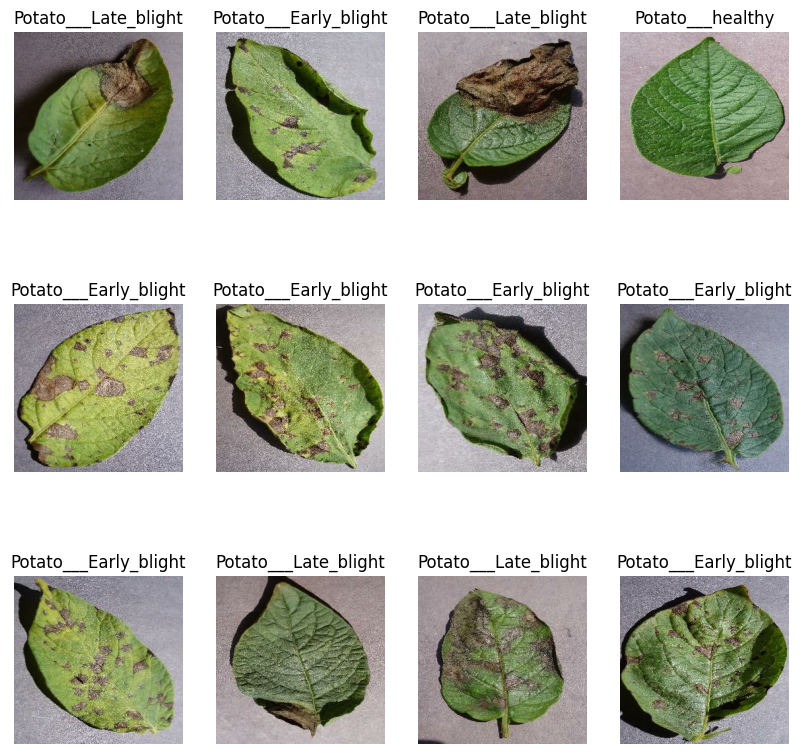

In [7]:
plt.figure(figsize=(10,10))
for image_batch,label_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3,4,i+1);
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])
        plt.axis("off")

In [8]:
train_size=0.8
len(dataset)*train_size

54.400000000000006

In [9]:
train_ds = dataset.take(54)
len(train_ds)

54

In [10]:
test_ds = dataset.skip(54)
len(test_ds)

14

In [11]:
val_size=0.1
len(dataset)*val_size

6.800000000000001

In [12]:
val_ds = test_ds.take(6)
len(val_ds)

6

In [13]:
test_ds = test_ds.skip(6)
len(test_ds)

8

In [14]:
def get_dataset_partitions_tf(ds, train_split=0.8,val_split=0.1,test_split=0.1, shuffle=True, shuffle_size=10000):
    ds_size = len(ds)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split*ds_size)
    
    train_ds = ds.take(train_size)
    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds,val_ds,test_ds

In [15]:
train_ds,val_ds,test_ds = get_dataset_partitions_tf(dataset)

In [16]:
len(train_ds)

54

In [17]:
len(test_ds)

8

In [18]:
len(val_ds)

6

In [19]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [20]:
resize_and_rescale = tf.keras.Sequential([
layers.experimental.preprocessing.Resizing(IMAGE_SIZE,IMAGE_SIZE),
layers.experimental.preprocessing.Rescaling(1./255),
])

In [21]:
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2),
    
])

In [22]:
train_ds = train_ds.map(
    lambda x,y: (data_augmentation(x,training=True),y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

In [23]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [24]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (32, 127, 127, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (32, 62, 62, 64)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (32, 60, 60, 64)         

In [25]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']


)

In [26]:
history = model.fit(
    train_ds,
    batch_size = BATCH_SIZE,
    validation_data = val_ds,
    verbose=1,
    epochs=5
)

Epoch 1/5
54/54 [==============================] - 115s 2s/step - loss: 0.8634 - accuracy: 0.5619 - val_loss: 0.6365 - val_accuracy: 0.7448
Epoch 2/5
54/54 [==============================] - 109s 2s/step - loss: 0.5961 - accuracy: 0.7483 - val_loss: 0.5744 - val_accuracy: 0.7656
Epoch 3/5
54/54 [==============================] - 116s 2s/step - loss: 0.4163 - accuracy: 0.8194 - val_loss: 0.3175 - val_accuracy: 0.9010
Epoch 4/5
54/54 [==============================] - 108s 2s/step - loss: 0.3335 - accuracy: 0.8623 - val_loss: 0.2708 - val_accuracy: 0.8906
Epoch 5/5
54/54 [==============================] - 116s 2s/step - loss: 0.1596 - accuracy: 0.9369 - val_loss: 0.2079 - val_accuracy: 0.9115


In [27]:
scores = model.evaluate(test_ds)


8/8 [==============================] - 5s 363ms/step - loss: 0.2131 - accuracy: 0.9224


In [28]:
scores

[0.21313947439193726, 0.9224137663841248]

In [29]:
history

In [30]:
history.params

{'verbose': 1, 'epochs': 5, 'steps': 54}

In [31]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [32]:
type(history.history['loss'])

list

In [33]:
len(history.history['loss'])

5

In [34]:
history.history['accuracy']

[0.5619212985038757,
 0.7482638955116272,
 0.8194444179534912,
 0.8622685074806213,
 0.9369212985038757]

In [35]:
history.history['loss'][:2] #show the loss for first 2 epochs


[0.8634063601493835, 0.5960570573806763]

In [36]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']


In [37]:
range(EPOCHS)

range(0, 5)

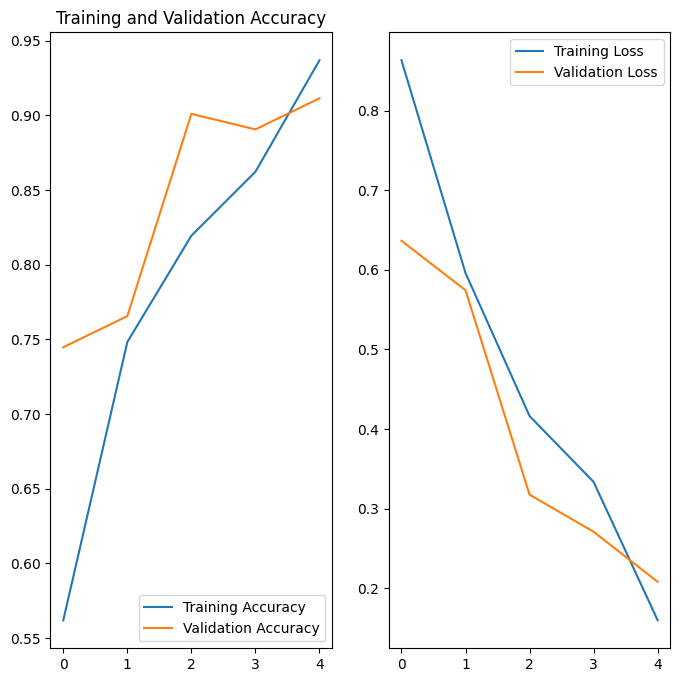

In [38]:
plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(range(EPOCHS),acc,label='Training Accuracy')
plt.plot(range(EPOCHS),val_acc,label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1,2,2)
plt.plot(range(EPOCHS),loss,label='Training Loss')
plt.plot(range(EPOCHS),val_loss,label='Validation Loss')
plt.legend(loc='upper right')


first image to predict
Potato___Late_blight
1/1 [==============================] - 1s 826ms/step
Potato___Late_blight


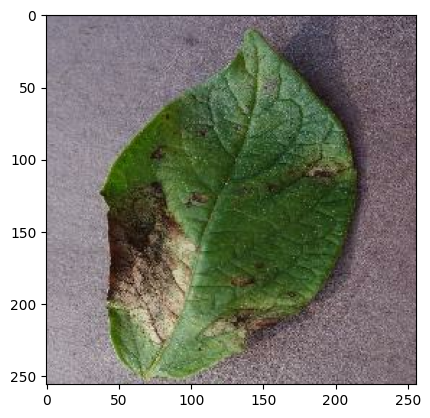

In [39]:
import numpy as np
for images_batch,labels_batch in test_ds.take(1):
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print(class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print(class_names[np.argmax(batch_prediction[0])])
    
    
    

In [61]:
plt.figure(figsize=(30,30))
# plt.subplot(11,3,i+1,constrained_layout = True)
for image,label in test_ds.take(1):
  predicted=new_model.predict(image)
  for i in range(len(image)):
    plt.subplot(11,3,i+1)
    plt.imshow(image[i].numpy().astype('uint32'))
    plt.tight_layout()
   # plt.subplots_adjust( 
    #                wspace=0.4, 
     #               hspace=1.5)
    actual_label=classes[label.numpy()[i]]
    predicted_label=classes[np.argmax(predicted[i])]
    confidence=round(100*np.max(predicted[i]),2)
    plt.title(f"actual: {actual_label}\npredicted: {predicted_label}\nconfidence= {confidence}",fontsize=20)
    plt.axis('off')
        

NameError: name 'new_model' is not defined

<Figure size 3000x3000 with 0 Axes>

AttributeError: 'function' object has no attribute 'predict'

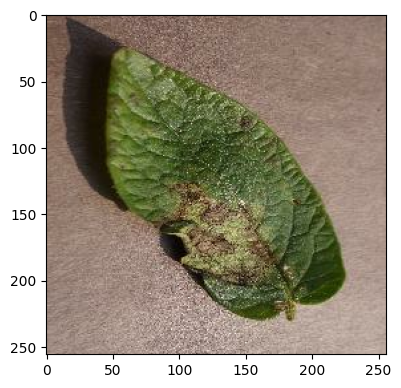

In [56]:
plt.figure(figsize=(15,15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3,3,i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model,images[i].numpy())
        actual_class = class_names[labels[i]]
        
        plt.title(f"Actual: {actual_class},\nPredicted: {predicted_class},\nConfidence :{confidence}%")
        
        

In [57]:
import os
model_version=max([int(i) for i in os.listdir("../models") + [0]])+1
model.save(f"../models/{model_version}")

AttributeError: 'function' object has no attribute 'save'